# 0. Imports

In [2]:
import numpy as np
import torch as t
import json
import matplotlib.pyplot as plt

from feature_circuits.activation_utils import SparseAct

from load_models import ModelLoader
from feature_ablation import AblationManager

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")

/home/aboehret/miniconda3/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aboehret/miniconda3/envs/sae/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
# Specify model and dictionary path
model_name = "EleutherAI/pythia-70m-deduped"
dictionary_path = "feature-circuits/dictionary_learning"

# Initialize the loader
loader = ModelLoader(model_name=model_name, dictionary_path=dictionary_path)

# Load the model, tokenizer, dictionaries, submodules, and names
model, tokenizer, dictionaries, submodules, submodule_names = loader.load_model()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# 1. Dataset

In [4]:
num_examples = 50
length = 3

dataset = './data/names.json'

male_prefixes = []
female_prefixes = []
dataset_items = open(dataset).readlines()
# random.shuffle(dataset_items)
for line in dataset_items:
    data = json.loads(line)
    male_prefixes.append(data["clean_prefix"])
    female_prefixes.append(data["patch_prefix"])

male_answers = [model.tokenizer.encode(' he')] 
female_answers = [model.tokenizer.encode(' she')] 


In [5]:
dataset = dict(
    clean_prefixes = male_prefixes,
    patch_prefixes = female_prefixes,
    clean_answers = male_answers,
    patch_answers = female_answers,
)

# 2. Ablation

In [6]:
# Initialise ablation object
ablation_manager = AblationManager(model, dictionaries, submodules)

## 2.1 Ablation of individual features

In [6]:
mapping = {
    '0-att-sm': 0, '1-att-sm': 1, '2-att-sm': 2, '3-att-sm': 3, '4-att-sm': 4, '5-att-sm': 5,
    '0-res-sm': 12, '1-res-sm': 13, '2-res-sm': 14, '3-res-sm': 15, '4-res-sm': 16, '5-res-sm': 17
}

original_list = [
    {'modelId': 'pythia-70m-deduped', 'layer': '3-res-sm', 'index': '31453'},
    {'modelId': 'pythia-70m-deduped', 'layer': '2-res-sm', 'index': '29295'},
    {'modelId': 'pythia-70m-deduped', 'layer': '0-att-sm', 'index': '19062'},
    {'modelId': 'pythia-70m-deduped', 'layer': '3-res-sm', 'index': '19558'},
    {'modelId': 'pythia-70m-deduped', 'layer': '3-res-sm', 'index': '27334'},
    {'modelId': 'pythia-70m-deduped', 'layer': '4-res-sm', 'index': '12420'},
    {'modelId': 'pythia-70m-deduped', 'layer': '4-res-sm', 'index': '30220'},
    {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '26074'},
    {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '10643'},
    {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '31975'},
    {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '14088'},
    {'modelId': 'pythia-70m-deduped', 'layer': '2-res-sm', 'index': '1995'},
    {'modelId': 'pythia-70m-deduped', 'layer': '2-att-sm', 'index': '27472'},
    {'modelId': 'pythia-70m-deduped', 'layer': '3-att-sm', 'index': '2959'},
    {'modelId': 'pythia-70m-deduped', 'layer': '3-att-sm', 'index': '19128'},
    {'modelId': 'pythia-70m-deduped', 'layer': '3-att-sm', 'index': '4659'},
    {'modelId': 'pythia-70m-deduped', 'layer': '4-att-sm', 'index': '31101'},
    {'modelId': 'pythia-70m-deduped', 'layer': '4-att-sm', 'index': '22821'},
    {'modelId': 'pythia-70m-deduped', 'layer': '5-att-sm', 'index': '22001'}
]

ablation_list = [{mapping[item['layer']]: int(item['index'])} for item in original_list]

print(ablation_list)


[{15: 31453}, {14: 29295}, {0: 19062}, {15: 19558}, {15: 27334}, {16: 12420}, {16: 30220}, {17: 26074}, {17: 10643}, {17: 31975}, {17: 14088}, {14: 1995}, {2: 27472}, {3: 2959}, {3: 19128}, {3: 4659}, {4: 31101}, {4: 22821}, {5: 22001}]


### 2.1.1 Zero Ablation feature wise

In [9]:
faith_zero = []
comp_zero = []
bias_zero = []

for i in ablation_list:
    fempty, fmodel, fc, faith, fcomp, comp, bias = ablation_manager.compute_ablation_onebyone(
        clean_prefixes=male_prefixes,
        patch_prefixes=None,
        clean_answers=male_answers,
        patch_answers=female_answers,
        ablation_id=i,
    )
    print(i, fcomp, faith, comp, bias)
    faith_zero.append((i, faith.item()))
    comp_zero.append((i, comp.item()))
    bias_zero.append((i, bias.item()))

print('FM', fmodel)
print('Fempty', fempty)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{15: 31453} tensor(-1.9533, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(1.0002, device='cuda:0') tensor(-0.0001, device='cuda:0')
{14: 29295} tensor(-1.9590, device='cuda:0') tensor(-2.5843e-05, device='cuda:0') tensor(1.0037, device='cuda:0') tensor(-0.0030, device='cuda:0')
{0: 19062} tensor(-1.9540, device='cuda:0') tensor(-0.0007, device='cuda:0') tensor(1.0006, device='cuda:0') tensor(-0.0005, device='cuda:0')
{15: 19558} tensor(-1.9613, device='cuda:0') tensor(-0.0043, device='cuda:0') tensor(1.0052, device='cuda:0') tensor(-0.0042, device='cuda:0')
{15: 27334} tensor(-1.7146, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(0.8516, device='cuda:0') tensor(0.1221, device='cuda:0')
{16: 12420} tensor(-1.9764, device='cuda:0') tensor(0.0029, device='cuda:0') tensor(1.0145, device='cuda:0') tensor(-0.0120, device='cuda:0')
{16: 30220} tensor(-1.6011, device='cuda:0') tensor(-5.0146e-05, device='cuda:0') tensor(0.7809, device='cuda:0') tensor(0.1802, device='cuda:0

Bias Score Reduction:
- 15: 27334
- 16: 30220
- 17: 10643
- 3: 19128
- 3: 4659
- 4: 22821

### 2.1.2 Resample Ablation feature wise

In [11]:
# resample 
faith_res = []
comp_res = []
bias_res= []
for i in ablation_list:
    fempty, fmodel, fc, faith, fcomp, comp, bias = ablation_manager.compute_ablation_onebyone(
        clean_prefixes=male_prefixes,
        patch_prefixes=female_prefixes,
        clean_answers=male_answers,
        patch_answers=female_answers,
        ablation_id=i,
    )
    print(i, fcomp, faith, comp, bias)
    faith_res.append((i,faith.item()))
    comp_res.append((i,comp.item()))
    bias_res.append((i,bias.item()))
print('FM', fmodel)
print('Fempty', fempty)

{15: 31453} tensor(-1.8772, device='cuda:0') tensor(0.0007, device='cuda:0') tensor(0.9678, device='cuda:0') tensor(0.0388, device='cuda:0')
{14: 29295} tensor(-1.5472, device='cuda:0') tensor(-0.0006, device='cuda:0') tensor(0.8275, device='cuda:0') tensor(0.2078, device='cuda:0')
{0: 19062} tensor(-1.9292, device='cuda:0') tensor(0.0003, device='cuda:0') tensor(0.9899, device='cuda:0') tensor(0.0122, device='cuda:0')
{15: 19558} tensor(-1.3977, device='cuda:0') tensor(-0.0001, device='cuda:0') tensor(0.7640, device='cuda:0') tensor(0.2843, device='cuda:0')
{15: 27334} tensor(-1.7422, device='cuda:0') tensor(0.0010, device='cuda:0') tensor(0.9104, device='cuda:0') tensor(0.1079, device='cuda:0')
{16: 12420} tensor(-1.2061, device='cuda:0') tensor(-0.0002, device='cuda:0') tensor(0.6825, device='cuda:0') tensor(0.3825, device='cuda:0')
{16: 30220} tensor(-1.6178, device='cuda:0') tensor(-0.0007, device='cuda:0') tensor(0.8575, device='cuda:0') tensor(0.1716, device='cuda:0')
{17: 26074

### 2.1.3 Plots

In [27]:
# Transform to array
bias_zero_array = np.array([item[1] for item in bias_zero])
bias_res_array = np.array([item[1] for item in bias_res])
faith_res_array = np.array([item[1] for item in faith_zero])
comp_res_array = np.array([item[1] for item in comp_res])

In [28]:
# Mapping of layer indices to layer names
layer_mapping = {
    0: 'attn_0', 1: 'attn_1', 2: 'attn_2', 3: 'attn_3', 4: 'attn_4', 5: 'attn_5',
    6: 'mlp_0', 7: 'mlp_1', 8: 'mlp_2', 9: 'mlp_3', 10: 'mlp_4', 11: 'mlp_5',
    12: 'resid_0', 13: 'resid_1', 14: 'resid_2', 15: 'resid_3', 16: 'resid_4', 17: 'resid_5'
}

In [29]:
# Extracting layer indices and feature IDs from your ablation list
layer_indices = [list(d.keys())[0] for d in ablation_list]
feature_ids = [list(d.values())[0] for d in ablation_list]


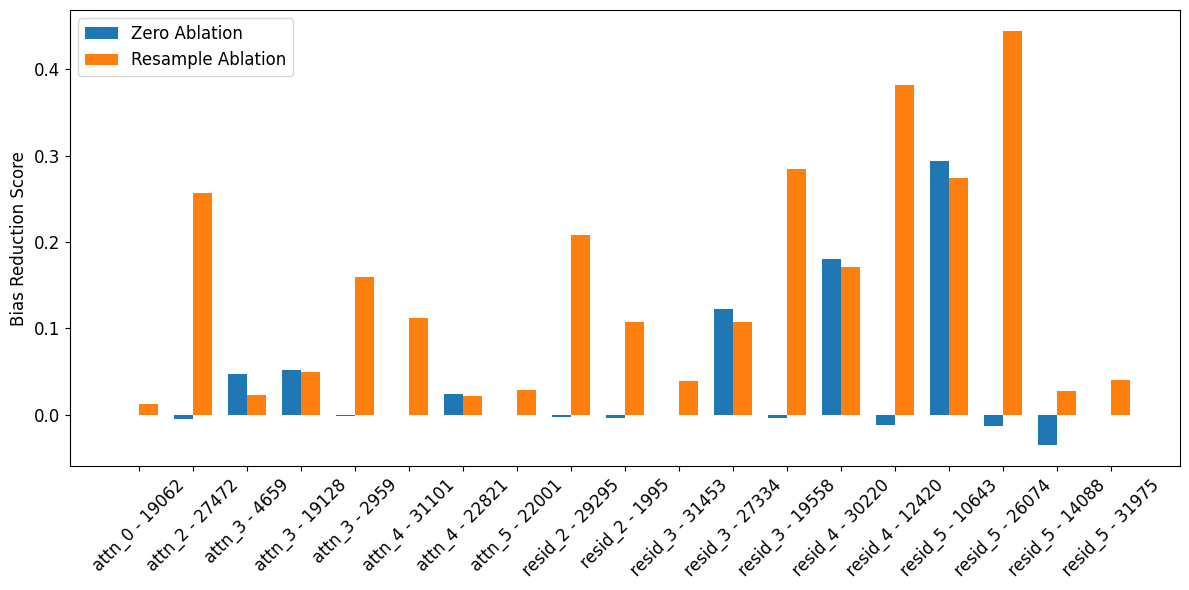

In [30]:

# Sorting the ablation list, bias_zero, and bias_resample by layer indices
sorted_indices = np.argsort(layer_indices)

# Sorting everything according to the layer indices
ablation_list_sorted = [ablation_list[i] for i in sorted_indices]
bias_zero_sorted = bias_zero_array[sorted_indices]
bias_resample_sorted = bias_res_array[sorted_indices]
feature_ids_sorted = [feature_ids[i] for i in sorted_indices]

# Extract the sorted layer indices and convert them to names
layer_indices_sorted = [list(d.keys())[0] for d in ablation_list_sorted]
layer_names_sorted = [layer_mapping[idx] for idx in layer_indices_sorted]

# Combine layer names and feature IDs for the x-axis labels
x_labels = [f'{layer_names_sorted[i]} - {feature_ids_sorted[i]}' for i in range(len(layer_names_sorted))]

# Width of bars
bar_width = 0.35

# Position of bars on x-axis
r1 = np.arange(len(layer_names_sorted))

# Create bars
plt.figure(figsize=(12, 6))
plt.bar(r1, bias_zero_sorted, width=bar_width, label='Zero Ablation')
plt.bar(r1 + bar_width, bias_resample_sorted, width=bar_width, label='Resample Ablation')

# Add labels and title with increased font size
plt.xlabel('Features', fontsize=12)
plt.ylabel('Bias Reduction Score', fontsize=12)
plt.xticks([r + bar_width/2 for r in range(len(x_labels))], x_labels, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Save the plot
plt.savefig("./figures/ablation_features.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


## 2.2 Ablation of complete layers

In [10]:
# Zero ablation of complete layers
f_layer = []
for i in range(18):
    fempty, fmodel, fc, faith, fcomp, comp, bias = ablation_manager.compute_ablation_layerwise(
        clean_prefixes=male_prefixes,
        patch_prefixes=None,
        clean_answers=male_answers,
        patch_answers=female_answers,
        ablation_layer=i,
        D_SAE = 32768,
    )
    f_layer.append((submodule_names[submodules[i]], faith.item(), comp.item(), bias.item()))


## 2.3 Ablation of complete submodules

In [8]:
# Zero ablation complete submodules
f_sub = []
for i in range(3):
    ablation_submodules = [i * 6 + j for j in range(6)]
    fempty, fmodel, fc, faith, fcomp, comp, bias = ablation_manager.compute_ablation_submodules(
        clean_prefixes=male_prefixes,
        patch_prefixes=None,
        clean_answers=male_answers,
        patch_answers=female_answers,
        ablation_submodules=ablation_submodules,
        D_SAE = 32768,
    )
    f_sub.append((submodule_names[submodules[i * 6]][:3], faith.item(), comp.item(), bias.item()))

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Plots for layers and submodules

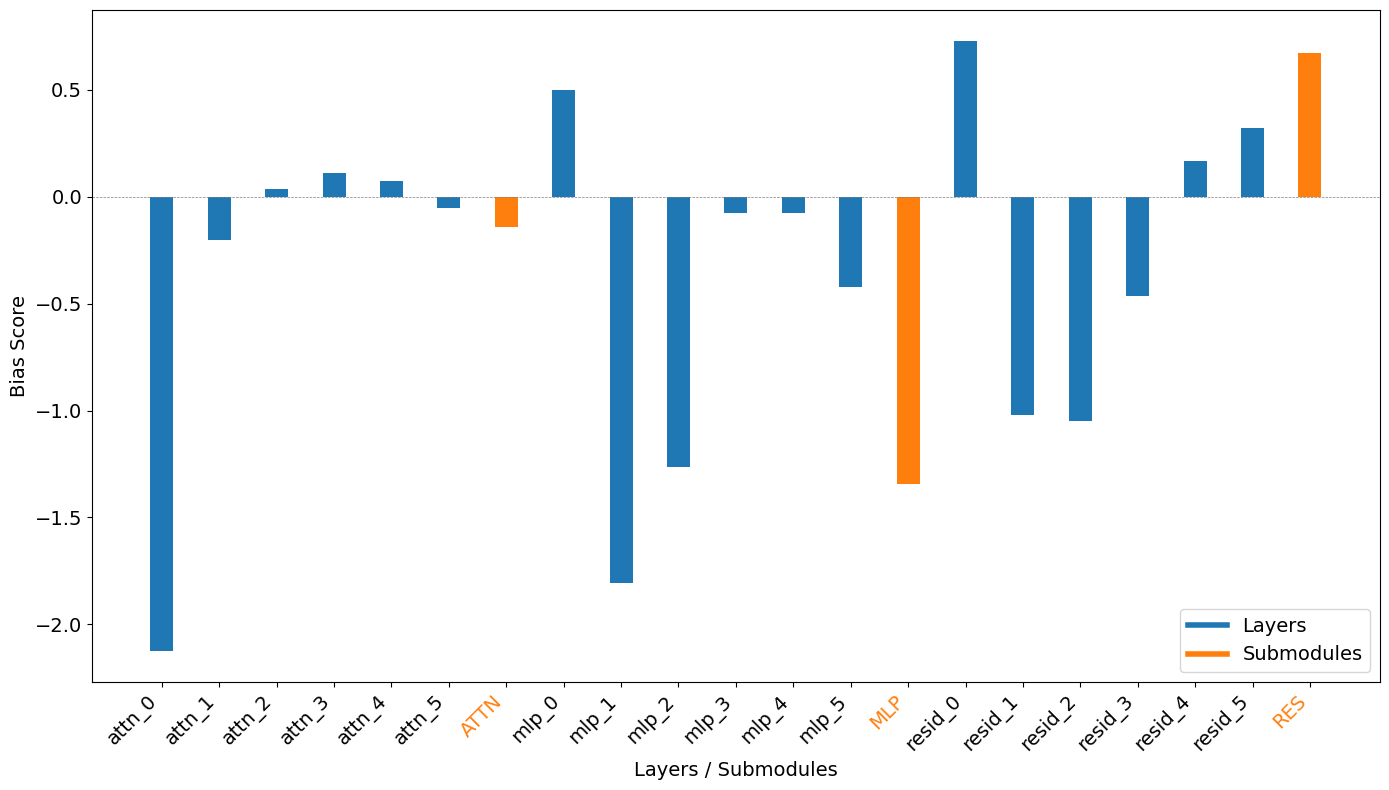

In [12]:
# Create a combined list for labels and values
combined_labels = []
combined_scores = []
bar_colors = []

# Add layers and their scores with Blue color
for item in f_layer:
    combined_labels.append(item[0])
    combined_scores.append(item[3])
    bar_colors.append('#1f77b4')  # Blue for individual layers

# Add submodules and their scores at appropriate positions with different colors
combined_labels.insert(6, 'ATTN')
combined_scores.insert(6, f_sub[0][3])
bar_colors.insert(6, '#ff7f0e')  # Orange for Attention

combined_labels.insert(13, 'MLP')
combined_scores.insert(13, f_sub[1][3])
bar_colors.insert(13, '#ff7f0e')  # Orange for MLP

combined_labels.append('RES')
combined_scores.append(f_sub[2][3])
bar_colors.append('#ff7f0e')  # Orange for Residual Stream

# Bar width and positions
bar_width = 0.4
x_indices = np.arange(len(combined_labels))

# Plotting the grouped bar chart
plt.figure(figsize=(14, 8))

# Combined bar chart for layers and submodules with color coding
plt.bar(x_indices, combined_scores, width=bar_width, color=bar_colors)

# Customizing the plot with font size adjustments
plt.ylabel('Bias Score', fontsize=14)
plt.xlabel('Layers / Submodules', fontsize=14)

# Customizing tick colors
tick_colors = []
for label in combined_labels:
    if label in ['ATTN', 'MLP', 'RES']:
        tick_colors.append('#ff7f0e')  # Orange for submodules
    else:
        tick_colors.append('black')  # Default black for other labels

# Setting tick labels with appropriate colors
xticks = plt.xticks(ticks=x_indices, labels=combined_labels, rotation=45, ha='right', fontsize=14)
for tick, color in zip(xticks[1], tick_colors):
    tick.set_color(color)

plt.yticks(fontsize=14)
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')

# Adding a legend for layers and submodules
blue_patch = plt.Line2D([0], [0], color='#1f77b4', lw=4, label='Layers')
orange_patch = plt.Line2D([0], [0], color='#ff7f0e', lw=4, label='Submodules')
plt.legend(handles=[blue_patch, orange_patch], loc='lower right', fontsize=14)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./figures/bias_layers_sub.png", dpi=300, bbox_inches='tight')
plt.show()


## 2.4 Ablate a set of features

In [7]:
# highest zero
biased_features_zero = [
    {15: 27334}, # resid_3
    {16: 30220}, # resid_4
    {17: 10643}, # resid_5
    {3: 4659}, # attn_3
    {3: 19128}, # attn_3
]

# highest resample
biased_features_res = [
    {16: 12420},  # resid_4
    {17: 26074},  # resid_5
    {15: 19558},   # resid_3
    {14: 29295},   # resid_2
    {2: 27472},   # attn_2
]

**Top Combinations**

1. **Zero Ablation**:
    - Combination: [{15: 27334}, {16: 30220}, {17: 10643}, {3: 4659}],
    - Bias Score: tensor(0.3739

2. **Resample Ablation**:
    - Combination: [{16: 12420}, {17: 26074}, {15: 19558}, {14: 29295}, {2: 27472}],
    - Bias_score: tensor(0.8295

### 2.4.1 Zero Ablation

In [8]:
bias_scores_zero, all_scores_zero = ablation_manager.ablate_feature_combinations(
    biased_feat=biased_features_zero,
    clean_prefixes=male_prefixes,
    patch_prefixes=female_prefixes,
    clean_answers=male_answers,
    patch_answers=female_answers,
)
# Top 5 bias scores for resample ablation
top_5_bias_scores_zero = sorted(bias_scores_zero, key=lambda x: x['bias_score'], reverse=True)[:5]
# top_5_bias_scores_zero

# Top 5 faithfulness scores for zero ablation
all_zero_5_faith = sorted(all_scores_zero, key=lambda x: x['faith_score'], reverse=True)[:5]
# all_zero_5_faith

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
all_zero_5 = sorted(all_scores_zero, key=lambda x: x['bias_score'], reverse=True)[:5]
all_zero_5

[{'combination': [{15: 27334}, {16: 30220}, {17: 10643}, {3: 4659}],
  'bias_score': 0.37386855483055115,
  'faith_score': 0.0002166123449569568,
  'comp_score': 0.6896581053733826},
 {'combination': [{15: 27334}, {16: 30220}, {17: 10643}, {3: 19128}],
  'bias_score': 0.3704921305179596,
  'faith_score': 0.001218202174641192,
  'comp_score': 0.692460834980011},
 {'combination': [{15: 27334},
   {16: 30220},
   {17: 10643},
   {3: 4659},
   {3: 19128}],
  'bias_score': 0.3704921305179596,
  'faith_score': 0.001218202174641192,
  'comp_score': 0.692460834980011},
 {'combination': [{15: 27334}, {16: 30220}, {17: 10643}],
  'bias_score': 0.3616442382335663,
  'faith_score': 0.0007761741289868951,
  'comp_score': 0.6998053193092346},
 {'combination': [{16: 30220}, {17: 10643}, {3: 19128}],
  'bias_score': 0.3559052050113678,
  'faith_score': 0.0001795243879314512,
  'comp_score': 0.7045692205429077}]

### 2.4.2 Resample Ablation

In [16]:
# Resample
bias_scores_res, all_scores_res = ablation_manager.ablate_feature_combinations(
    biased_feat=biased_features_res,
    clean_prefixes=male_prefixes,
    patch_prefixes=female_prefixes,
    clean_answers=male_answers,
    patch_answers=female_answers,
)
# Top 5 bias scores for resample ablation
top_5_bias_scores_res = sorted(bias_scores_res, key=lambda x: x['bias_score'], reverse=True)[:5]
# top_5_bias_scores_res

# Top 5 faithfulness scores for resample ablation
all_res_5_faith = sorted(all_scores_res, key=lambda x: x['faith_score'], reverse=True)[:5]
# all_res_5_faith

In [18]:
# Top 5 bias scores for plotting
all_res_5 = sorted(all_scores_res, key=lambda x: x['bias_score'], reverse=True)[:5]
all_res_5

[{'combination': [{16: 12420},
   {17: 26074},
   {15: 19558},
   {14: 29295},
   {2: 27472}],
  'bias_score': 0.8294571042060852,
  'faith_score': 0.0043814945966005325,
  'comp_score': 0.311481773853302},
 {'combination': [{16: 12420}, {17: 26074}, {14: 29295}, {2: 27472}],
  'bias_score': 0.8085311651229858,
  'faith_score': 0.0054762098006904125,
  'comp_score': 0.3288520574569702},
 {'combination': [{16: 12420}, {17: 26074}, {15: 19558}, {2: 27472}],
  'bias_score': 0.795019268989563,
  'faith_score': 0.005266602151095867,
  'comp_score': 0.3400680720806122},
 {'combination': [{17: 26074}, {15: 19558}, {14: 29295}, {2: 27472}],
  'bias_score': 0.793982982635498,
  'faith_score': 0.008865184150636196,
  'comp_score': 0.34092825651168823},
 {'combination': [{16: 12420}, {17: 26074}, {15: 19558}, {14: 29295}],
  'bias_score': 0.7934516668319702,
  'faith_score': 0.005486849695444107,
  'comp_score': 0.34136927127838135}]

### 2.4.3 Plots

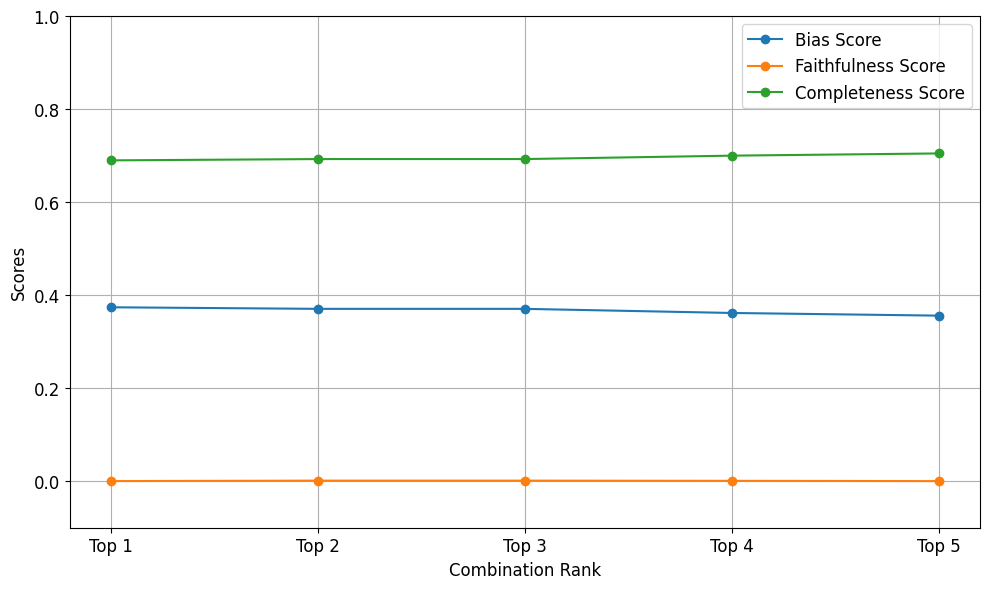

In [14]:
# Plot Zero Ablation Results

# Extracting scores for plotting
labels = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5']
bias_scores = [item['bias_score'] for item in all_zero_5]
faith_scores = [item['faith_score'] for item in all_zero_5]
comp_scores = [item['comp_score'] for item in all_zero_5]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(labels, bias_scores, marker='o', label='Bias Score')
plt.plot(labels, faith_scores, marker='o', label='Faithfulness Score')
plt.plot(labels, comp_scores, marker='o', label='Completeness Score')

# Adding labels and increasing font size
plt.xlabel('Combination Rank', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(-0.1, 1)  # Set y-axis from -0.1 to 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./figures/evaluation_scores_zero.png", dpi=300, bbox_inches='tight')
plt.show()


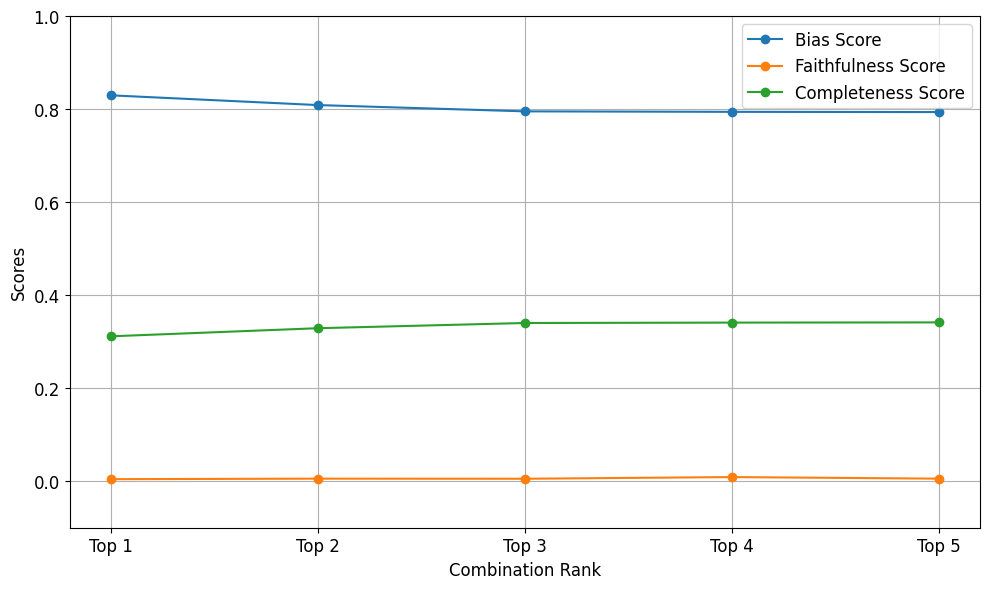

In [19]:
# Plot Resample Ablation Results

# Extracting scores for plotting
labels = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5']
bias_scores = [item['bias_score'] for item in all_res_5]
faith_scores = [item['faith_score'] for item in all_res_5]
comp_scores = [item['comp_score'] for item in all_res_5]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(labels, bias_scores, marker='o', label='Bias Score')
plt.plot(labels, faith_scores, marker='o', label='Faithfulness Score')
plt.plot(labels, comp_scores, marker='o', label='Completeness Score')

# Adding labels and increasing font size
plt.xlabel('Combination Rank', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(-0.1, 1)  # Set y-axis from -0.1 to 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("./figures/evaluation_scores.png", dpi=300, bbox_inches='tight')
plt.show()
